# Quality Time

In [1]:
%autosave 0
%load_ext autoreload
%autoreload 2

from tools import F1_ZIPPED
from etl.ergast import ErgastF1
from viz.plot import Plot

f1 = ErgastF1(F1_ZIPPED)
plot = Plot()

Autosave disabled


## lights out
Qualifying times as % of best time.

In [2]:
qtimes = (
    f1.qualifying
    .join(f1.drivers['driver'], on='id_driver')
    .join(f1.races['id_circuit round season'.split()], on='id_race')
    .join(f1.circuits['circuit'], on='id_circuit')
    .assign(seconds = lambda df: df['q1 q2 q3'.split()].min(axis=1))
    .sort_values('season round pos'.split())
    ['season round circuit driver pos seconds'.split()]
)
qtimes

,season,round,circuit,driver,pos,seconds
2594,1994,1,Autódromo José Carlos Pace,Ayrton Senna,1,75.962
2595,1994,1,Autódromo José Carlos Pace,Michael Schumacher,2,76.290
2596,1994,1,Autódromo José Carlos Pace,Jean Alesi,3,77.385
2597,1994,1,Autódromo José Carlos Pace,Damon Hill,4,77.554
2598,1994,1,Autódromo José Carlos Pace,Heinz-Harald Frentzen,5,77.806
...,...,...,...,...,...,...
8373,2019,21,Yas Marina Circuit,Romain Grosjean,16,98.051
8374,2019,21,Yas Marina Circuit,Antonio Giovinazzi,17,98.114
8375,2019,21,Yas Marina Circuit,Kimi Räikkönen,18,98.383
8376,2019,21,Yas Marina Circuit,George Russell,19,98.717


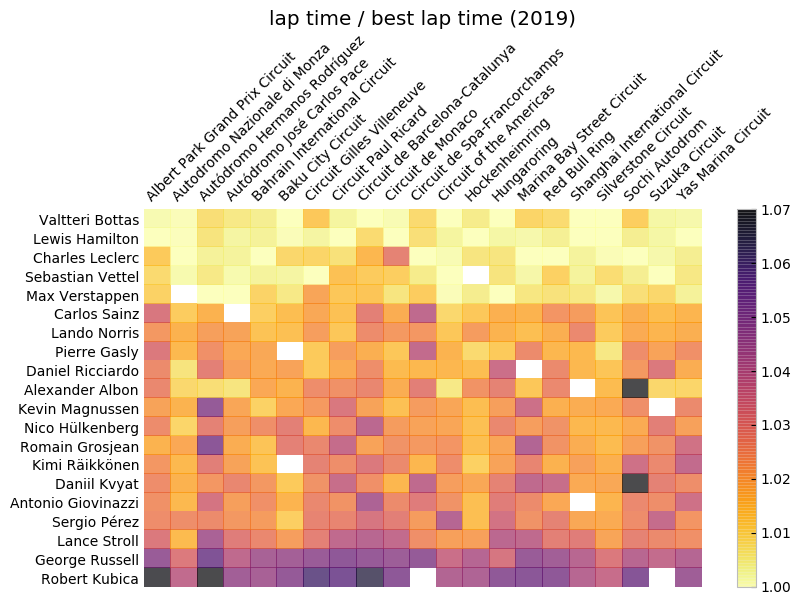

In [3]:
def hotlaps(data, season, limit=1.07, **kwargs):

    data = data[data['season'].eq(season)]
    data = data.pivot(index='driver', columns='circuit', values='seconds')
    data = data.div(data.min(axis=0), axis=1).clip(upper=limit)
    data = data.loc[data.median(axis=1).sort_values().index]
        
    kwset = kwargs.setdefault
    kwset('cmap', 'inferno_r')
    kwset('title', f"lap time / best lap time ({season})")
    plot.heat(data, **kwargs)
    
hotlaps(qtimes, 2019)

## away we go
First lap time as % of best first lap time.

In [4]:
starts = (
    f1.lap_times[lambda df: df['lap'].eq(1)]
    .join(f1.drivers['driver'], on='id_driver')
    .join(f1.races['id_circuit round season'.split()], on='id_race')
    .join(f1.circuits['circuit'], on='id_circuit')
    .sort_values('season round pos'.split())
    ['season round circuit driver pos seconds'.split()]
)
starts

,season,round,circuit,driver,pos,seconds
114009,1996,1,Albert Park Grand Prix Circuit,Jacques Villeneuve,1,103.702
113951,1996,1,Albert Park Grand Prix Circuit,Damon Hill,2,104.243
113826,1996,1,Albert Park Grand Prix Circuit,Eddie Irvine,3,104.981
113794,1996,1,Albert Park Grand Prix Circuit,Michael Schumacher,4,105.188
113884,1996,1,Albert Park Grand Prix Circuit,Jean Alesi,5,106.506
...,...,...,...,...,...,...
472236,2019,21,Yas Marina Circuit,Daniil Kvyat,16,115.917
472290,2019,21,Yas Marina Circuit,Romain Grosjean,17,116.282
472344,2019,21,Yas Marina Circuit,Robert Kubica,18,117.409
472397,2019,21,Yas Marina Circuit,George Russell,19,117.917


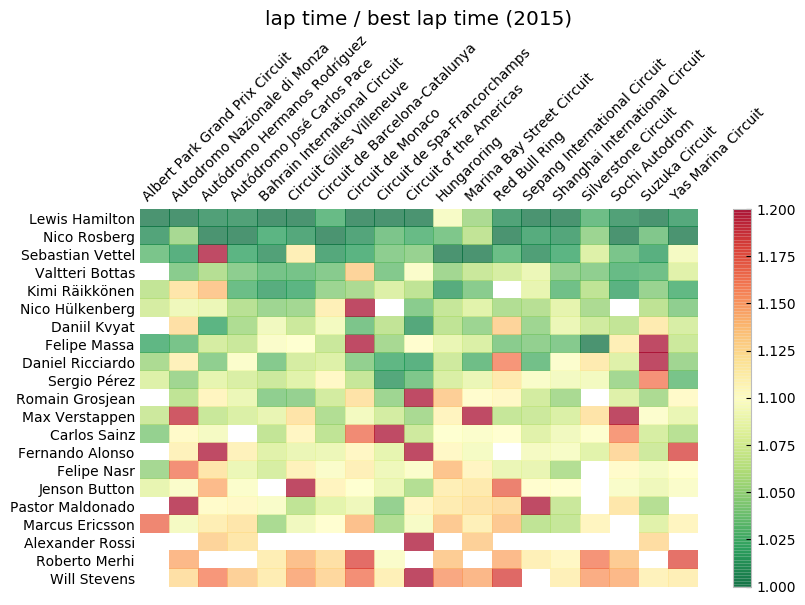

In [5]:
hotlaps(starts, 2015, limit=1.20, cmap='RdYlGn_r')

## over the line
Worst violations of 107% rule.

In [6]:
data = qtimes.set_index('season circuit driver'.split())['seconds']
data /= data.groupby(level=[0,1]).min()
data.name = 'qfactor'
data.nlargest(20).reset_index()

,season,circuit,driver,qfactor
0,1995,Suzuka Circuit,Mark Blundell,10.228620
1,2016,Hungaroring,Rio Haryanto,1.377965
2,2016,Hungaroring,Pascal Wehrlein,1.342375
3,2016,Hungaroring,Marcus Ericsson,1.337885
4,2005,Albert Park Grand Prix Circuit,Michael Schumacher,1.335890
5,2004,Autodromo Enzo e Dino Ferrari,Zsolt Baumgartner,1.332853
6,2010,Circuit de Spa-Francorchamps,Lucas di Grassi,1.311747
7,2016,Hungaroring,Kevin Magnussen,1.307359
8,2016,Hungaroring,Felipe Massa,1.300556
9,2016,Hungaroring,Jolyon Palmer,1.300131
